This notebook contains the code used to make the data split we saved locally and used through all the experiments. It also contain the relevant code for oversampling, minMax scalar and robust Scalar. In the second part there is the code to perform time series to image mapping and training of EfficientNetV2B3 with Gap+softmax and with the dense layer applyes filtering features and passing them in the color channels. Also a custom model that did not work.
At the end a trial of using scikit AdaBoost with keras models that did not work for compatibilities issues

In [ ]:
from google.colab import drive
drive.mount("./gdrive")

Mounted at ./gdrive


In [ ]:
import pickle
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization, Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomContrast, Rescaling, AveragePooling2D
import numpy as np
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd

# (Run only if data on disck not available) Data split and preparation for stored split in the disck

pickle save operation commented to avoid accidental overwriting, uncomment to save


In [ ]:
# Only for data preparation
x_original = np.load('./gdrive/MyDrive/ann_dataset/HW2/x_train.npy') # Shape: (2429, 36, 6)
y_original = np.load('./gdrive/MyDrive/ann_dataset/HW2/y_train.npy') # Labels

# extreme outliers
x_original[758][32] = x_original[758][31]
x_original[22][22] = x_original[22][21]

train_test_obj = train_test_split(x_original, y_original, test_size=0.2, shuffle=True)
x, x_test, y, y_test = train_test_obj

""" !! with open("./gdrive/MyDrive/ann_dataset/HW2/dataUsed/train_test_objKeep9", "wb") as f:
  pickle.dump(train_test_obj, f)"""


In [ ]:
x.shape, x_test.shape

((1943, 36, 6), (486, 36, 6))

In [ ]:
tabular_list = []
for i_sample, x in enumerate(x_original):
    for i_time, xx in enumerate(x):
        tabular_list.append([i_sample, i_time] + list(xx) + [y_original[i_sample]])
df = pd.DataFrame(tabular_list).rename(columns={
        0: 'sample_id',
        1: 'time',
        2: 'feat_1',
        3: 'feat_2',
        4: 'feat_3',
        5: 'feat_4',
        6: 'feat_5',
        7: 'feat_6',
        8: 'label'}, inplace=False, errors='raise')
df

,sample_id,time,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,label
0,0,0,17.59700,8.17130,-1.78420,-19.70600,-9.71350,-61.8870,0
1,0,1,0.22974,-5.89560,16.83700,5.03900,2.43320,58.9140,0
2,0,2,-29.65400,-21.29600,29.10300,-0.47503,75.39100,10.6650,0
3,0,3,-59.21000,-29.56500,17.97100,-45.60600,19.41200,-43.0140,0
4,0,4,-72.06400,-25.85500,0.46536,-59.15100,-29.10500,-11.9130,0
...,...,...,...,...,...,...,...,...,...
87439,2428,31,3.51190,-1.03240,-1.69900,4.15790,2.75430,5.9823,11
87440,2428,32,0.70853,-0.94622,-1.91760,2.09480,-4.76750,7.4118,11
87441,2428,33,0.20638,1.02870,-0.92512,-0.71633,1.73330,4.7638,11
87442,2428,34,4.14290,1.09390,-0.18921,1.14100,0.93441,4.1742,11


In [ ]:
x_original[758][32]

array([15916. ,  7136.6,  5969.6,  5503.3,  5062.1,  7830.5])

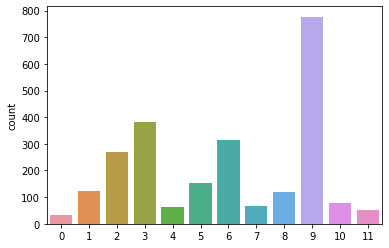

In [ ]:
sns.countplot(x = y_original)

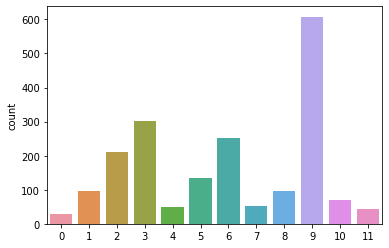

In [ ]:
sns.countplot(x=y)

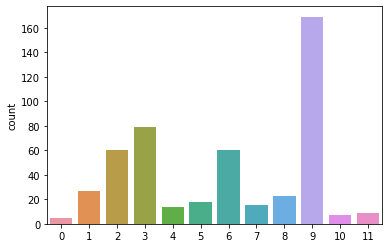

In [ ]:
sns.countplot(x = y_test)

In [ ]:
x.shape

(1943, 36, 6)

Number of samples for each class before oversampling: {0: 30, 1: 101, 2: 225, 3: 298, 4: 49, 5: 121, 6: 244, 7: 60, 8: 95, 9: 620, 10: 59, 11: 41}
Number of samples to add for class 0 : 270
Number of samples to add for class 1 : 199
Number of samples to add for class 2 : 75
Number of samples to add for class 3 : 2
Number of samples to add for class 4 : 251
Number of samples to add for class 5 : 179
Number of samples to add for class 6 : 56
Number of samples to add for class 7 : 240
Number of samples to add for class 8 : 205
Number of samples to add for class 10 : 241
Number of samples to add for class 11 : 259
Number of samples for each class after oversampling: {0: 300, 1: 300, 2: 300, 3: 300, 4: 300, 5: 300, 6: 300, 7: 300, 8: 300, 9: 620, 10: 300, 11: 300}


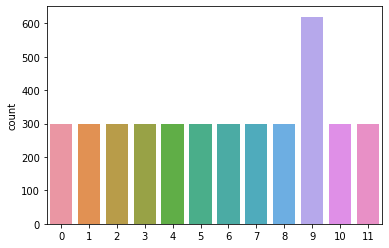

In [ ]:
x_tmp = np.delete(x, np.where(y == 9)[0][:300], axis=0)
y_tmp = np.delete(y, np.where(y == 9)[0][:300], axis=0)


x_oversampled, y_oversampled = oversample_minority_classes(x_tmp, y_tmp)
sns.countplot(x = y_oversampled)

In [ ]:
train_test_obj_oversampled = x_oversampled, x_test, y_oversampled, y_test

""" !! with open("./gdrive/MyDrive/ann_dataset/HW2/dataUsed/train_test_obj_oversampledkeep9", "wb") as f:
  pickle.dump(train_test_obj_oversampled, f)"""

In [ ]:
# Oversample the minority classes
def oversample_minority_classes(x_train, y_train):
    # Count the number of samples for each class
    unique, counts = np.unique(y_train, return_counts=True)
    print('Number of samples for each class before oversampling:', dict(zip(unique, counts)))
    # Oversample the minority classes
    minority_classes = np.where(counts < 300)[0]
    for i in minority_classes:
        # Calculate the number of samples to add
        num_samples_to_add = int(300) - counts[i]
        print('Number of samples to add for class', i, ':', num_samples_to_add)
        # Randomly select samples from the x_train data that belong to the minority class i
        idx = np.random.choice(np.where(y_train == i)[0], num_samples_to_add)
    
        """
        DATA AUGMENTATION
        """
        # Augment the selected sample by adding random noise
        # augmented_samples = x_train[idx] + np.random.normal(0, GAUSSIAN_NOISE, x_train[idx].shape)
        augmented_samples = x_train[idx]
        
        
        # Add the selected samples to the x_train data
        x_train = np.concatenate((x_train, augmented_samples), axis=0)
        # Add the corresponding labels to the y_train data
        y_train = np.concatenate((y_train, y_train[idx]), axis=0)
        
    # Count the number of samples for each class
    unique, counts = np.unique(y_train, return_counts=True)
    print('Number of samples for each class after oversampling:', dict(zip(unique, counts)))
    
    # Shuffle the data
    p = np.random.permutation(len(x_train))
    x_train = x_train[p]
    y_train = y_train[p]
    
    return x_train, y_train

# Data Load

In [ ]:
# load data split
with open("./gdrive/MyDrive/ann_dataset/HW2/dataUsed/train_test_obj_oversampledkeep9", "rb") as f:
  x_trainO, x_testO, y_trainO, y_testO = pickle.load(f)

In [ ]:
# load data split
with open("./gdrive/MyDrive/ann_dataset/HW2/dataUsed/train_test_objKeep9", "rb") as f:
  x_train, x_test, y_train, y_test = pickle.load(f)

In [ ]:
x_train.shape[0] + x_test.shape[0]

4406

In [ ]:
np.bincount(y_train)

array([300, 300, 300, 300, 300, 300, 300, 300, 300, 620, 300, 300])

# Utils Functions

In [ ]:
def from_raw_to_dataframe(x_raw, y_raw):
    tabular_list = []
    for i_sample, x in enumerate(x_raw):
        for i_time, xx in enumerate(x):
            tabular_list.append([i_sample, i_time] + list(xx) + [y_raw[i_sample]])
    df_res = pd.DataFrame(tabular_list).rename(columns={
        0: 'sample_id',
        1: 'time',
        2: 'feat_1',
        3: 'feat_2',
        4: 'feat_3',
        5: 'feat_4',
        6: 'feat_5',
        7: 'feat_6',
        8: 'label'}, inplace=False, errors='raise')
    return df_res

In [ ]:
def build_sequences(df):
    # Sanity check to avoid runtime errors
    #assert window % stride == 0
    dataset = []
    labels = []
    for id in df['sample_id'].unique():
        # Take only meaningful features
        temp = df[df['sample_id'] == id][['feat_1','feat_2','feat_3','feat_4','feat_5','feat_6']].values
        # Save the label
        label = df[df['sample_id'] == id]['label'].values[0]
        labels.append(label)
        dataset.append(temp)

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler


def normalize_data_feature_wise(x_original, y_original, max_value=1, quantile=False):
    x_original_tabular = from_raw_to_dataframe(x_original, y_original)
    if quantile:
        scaler = RobustScaler()
    else:
        scaler = MinMaxScaler(feature_range=(0, max_value))
    scaler.fit_transform(x_original_tabular[['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']])
    x_original_tabular[['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']] = scaler.transform(
        x_original_tabular[['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']])

    agg_x, agg_y = build_sequences(x_original_tabular)
    return agg_x, agg_y, scaler

In [ ]:
def apply_scaler_to_new_data(x,y,scaler):
  x_original_tabular = from_raw_to_dataframe(x, y)
  x_original_tabular[['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']] = scaler.transform(x_original_tabular[['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6']])
  agg_x, agg_y = build_sequences(x_original_tabular)
  return agg_x, agg_y

In [ ]:
def shiftLeft(lst) :
    return lst[1:] + lst[:1]

def shiftRight(lst) :
    return lst[-1:] + lst[:-1]

def array_1D_to_2D(array, option=2):
  """ mappind 1D arrays to 2D images like arrays with the specified option"""
  base = list(array.copy())
  twoD_array = []

  if option == 0:
  # every row do a right shift
      for i in range(len(base)):
          twoD_array.append(base)
          base = shiftLeft(base)
  elif option == 1:
  # for iteration i do i right shifts of previous row
      for i in range(len(base)):
          twoD_array.append(base)
          for _ in range(i):
              base = shiftLeft(base)
  elif option == 2:
  # shift the same number of filter size (3)
      for i in range(len(base)):
          twoD_array.append(base)
          for _ in range(3):
              base = shiftLeft(base)
  return twoD_array

In [ ]:
def original_data_to_image_data(x, y, option):
  """ Given a time series of size N return an image NxN created using the specified option, implementation in the cell above"""
    x_image = []
    y_image = []

    for i, label in enumerate(y):
        images_block = []
        for feat_id in range(x[i].shape[1]):
            ts = np.array(x[i][:, feat_id]) #extract time series
            image = array_1D_to_2D(ts, option=option)
            images_block.append(image)

        x_image.append(np.array(images_block))
        y_image.append(np.array(label))
        # reshape to use second option of accessing
        # x_original_image[0][0, :]
        # x_original_image_r[0][:,:, 0]
    x_image_r = np.reshape(x_image, (len(x), 36, 36, 6))
    return x_image_r, y_image

In [ ]:
def wrapper_feature_rgb(cnn_model):
  """ keep only first 3 dimention and feed it to an rgb image classifier, each feature for each color channel """
  model_input = tfk.Input(shape=(36,36,6))
  l1 = tfk.layers.Lambda(lambda x: x[:,:,:,:3], input_shape=(36, 36))(model_input)  # filter 3 channels
  """l2 = tfk.layers.Lambda(lambda x: x[:,:,:,1], input_shape=(36, 36))(model_input)
  l3 = tfk.layers.Lambda(lambda x: x[:,:,:,2], input_shape=(36, 36))(model_input)"""
  model_output = cnn_model(l1)
  cnn_ready_model = tfk.Model(inputs=model_input, outputs=model_output)
  return cnn_ready_model

In [ ]:
# wrapper function that return a model composed by  pretrained model + custom FFNN as classifier at the end
def bottom_model_builder_classifier(
    base_model,
    dropout_rate=0.3,
    size_dense =1000
    ):
  l2_lambda = 1e-2
  inputs=tfk.Input(shape=(36, 36, 3))
  x = base_model(inputs)
  x = Flatten()(x)
  x = Dense(size_dense, activation='swish', kernel_initializer = tfk.initializers.HeUniform())(x)
  x = Dropout(dropout_rate, name="top_dropout_2")(x)
  x = Dense(256, activation='swish', kernel_initializer = tfk.initializers.HeUniform())(x)
  x = Dropout(dropout_rate, name="top_dropout_3")(x)
  outputs = tfkl.Dense(
      12, 
      activation='softmax',
      kernel_initializer = tfk.initializers.GlorotUniform())(x)


  # Connect input and output through the Model class
  tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='Densemodel')

  return tl_model

In [ ]:
# return a GAP + softmax CNN from the given base feature extractor
def bottom_model_builder_fully_conv(
        base_model,
        dropout_rate,
):

    inputs=tfk.Input(shape=(36, 36, 3))
    x = base_model(inputs)
    x = tfkl.GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate, name="top_dropout")(x)
    outputs = tfkl.Dense(
        12,
        activation='softmax',
        kernel_initializer = tfk.initializers.GlorotUniform())(x)


    # Connect input and output through the Model class
    tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='FullConvmodel')

    return tl_model

# Data to image mapping

In [ ]:
OPTION = 0

In [ ]:
x_train.shape, x_test.shape

((3920, 36, 6), (486, 36, 6))

In [ ]:
NORMALIZATION = True
if NORMALIZATION:
  x_train_norm, y_train_norm, scaler = normalize_data_feature_wise(x_train, y_train, quantile=True)
  x_test_norm, y_test_norm = apply_scaler_to_new_data(x_test, y_test, scaler)
  x_train_normO, y_train_normO= apply_scaler_to_new_data(x_trainO, y_trainO, scaler)
  x_test_normO, y_test_normO = apply_scaler_to_new_data(x_testO, y_testO, scaler)
else:
  x_train_norm, y_train_norm = x_train, y_train
  x_test_norm, y_test_norm = x_test, y_test


In [ ]:
np.mean(x_train_norm), np.max(x_train_norm), np.min(x_train_norm) # explore if normalization happened

(1.8948982610661986, 4043.1959847507133, -1967.3664388330392)

In [ ]:
np.mean(x_test_norm), np.max(x_test_norm), np.min(x_train_norm) # explore if normalization happened

(2.4541342982216214, 5816.222747418829, -1967.3664388330392)

In [ ]:
assert np.sum(y_test == y_test_norm) == len(y_test_norm) # check that data order is not perturbed

In [ ]:
x_train_image, y_train_image = original_data_to_image_data(x_train_norm, y_train_norm, option=OPTION)
x_test_image, y_test_image = original_data_to_image_data(x_test_norm, y_test_norm, option=OPTION)

In [ ]:
assert np.sum(y_train_image== y_train_norm) == len(y_train_norm) # check that data order is not perturbed
assert np.sum(y_test_image== y_test_norm) == len(y_test_norm) # check that data order is not perturbed

In [ ]:
x_train_image.shape, x_test_image.shape 

((3920, 36, 36, 6), (486, 36, 36, 6))

# Custom cnn

In [ ]:
def custom_model(input_shape, seed=0):
  model = Sequential()
  l2_lambda = 1e-4

  model.add(
      Conv2D(
          filters=16,
          strides=(1,1),
          kernel_size=(12,12), 
          activation='relu',
          padding='same',
          input_shape=input_shape,
          kernel_regularizer=tfk.regularizers.L2(l2_lambda),
          kernel_initializer = tfk.initializers.HeUniform(seed)))
  model.add(MaxPool2D(pool_size=(2,2)))

  model.add(
      Conv2D(
          filters=32,
          strides=(1,1),
          kernel_size=(3,3), 
          activation='relu',
          padding='same',
          input_shape=input_shape,
          kernel_regularizer=tfk.regularizers.L2(l2_lambda),
          kernel_initializer = tfk.initializers.HeUniform(seed)))
  model.add(MaxPool2D(pool_size=(2,2)))

  model.add(
      Conv2D(
          filters=64,
          strides=(1,1),
          kernel_size=(3,3), 
          activation='relu',
          padding='same',
          input_shape=input_shape,
          kernel_regularizer=tfk.regularizers.L2(l2_lambda),
          kernel_initializer = tfk.initializers.HeUniform(seed)))
  model.add(MaxPool2D(pool_size=(2,2)))

  model.add(
      Conv2D(
          filters=128,
          strides=(1,1),
          kernel_size=(3,3), 
          activation='relu',
          padding='same',
          input_shape=input_shape,
          kernel_regularizer=tfk.regularizers.L2(l2_lambda),
          kernel_initializer = tfk.initializers.HeUniform(seed)))
  model.add(
      Conv2D(
          filters=128,
          strides=(1,1),
          kernel_size=(3,3), 
          activation='relu',
          padding='same',
          input_shape=input_shape,
          kernel_regularizer=tfk.regularizers.L2(l2_lambda),
          kernel_initializer = tfk.initializers.HeUniform(seed)))
  model.add(MaxPool2D(pool_size=(2,2)))

  model.add(
      Conv2D(
          filters=256,
          strides=(1,1),
          kernel_size=(3,3), 
          activation='relu',
          padding='same',
          input_shape=input_shape,
          kernel_regularizer=tfk.regularizers.L2(l2_lambda),
          kernel_initializer = tfk.initializers.HeUniform(seed)))
  model.add(
      Conv2D(
          filters=256,
          strides=(1,1),
          kernel_size=(3,3), 
          activation='relu',
          padding='same',
          input_shape=input_shape,
          kernel_regularizer=tfk.regularizers.L2(l2_lambda),
          kernel_initializer = tfk.initializers.HeUniform(seed)))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Flatten())
  model.add(Dropout(0.2,seed=seed))
  model.add(Dense(1000,kernel_regularizer=tfk.regularizers.L2(l2_lambda), activation='selu'))
  model.add(Dropout(0.2,seed=seed))
  model.add(Dense(12, activation='softmax', kernel_initializer = tfk.initializers.HeUniform(seed)))
  return model

# CNN training 2D - EfficientNetV2B3
 trying to feed 3 feature of the timeseris mapped from 1d to 3d as RGB channels of an image

In [ ]:
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_image, y_train_image)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_image, y_test_image)).batch(BATCH_SIZE)

In [ ]:
# callback list
callbacks_list = []
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=50, restore_best_weights=True)
callbacks_list.append(es_callback)


In [ ]:
if False:
  SELECTED_MODEL = tfk.applications.EfficientNetV2B3
  base_model = SELECTED_MODEL(input_shape=(36,36,3),
                            include_top=False,
                            weights='imagenet')
  base_model.trainable = False

In [ ]:
base_model = custom_model(input_shape=(36,36,3))

In [ ]:
#model = bottom_model_builder_fully_conv(base_model, dropout_rate=0.3)
model_vanilla = bottom_model_builder_classifier(base_model, dropout_rate=0.3, size_dense=6000)
model = wrapper_feature_rgb(model_vanilla)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 36, 36, 6)]       0         
                                                                 
 lambda_1 (Lambda)           (None, 36, 36, 3)         0         
                                                                 
 Densemodel (Functional)     (None, 12)                3023104   
                                                                 
Total params: 3,023,104
Trainable params: 3,023,104
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])

In [ ]:
history = model.fit(train_dataset,
          validation_data=test_dataset,
          epochs=200,
          callbacks=callbacks_list).history

Epoch 1/200
57/57 [==============================] - 2s 16ms/step - loss: 2.7401 - sparse_categorical_accuracy: 0.0888 - val_loss: 2.5692 - val_sparse_categorical_accuracy: 0.2675
Epoch 2/200
57/57 [==============================] - 1s 10ms/step - loss: 2.5852 - sparse_categorical_accuracy: 0.0820 - val_loss: 2.5366 - val_sparse_categorical_accuracy: 0.2675
Epoch 3/200
57/57 [==============================] - 1s 10ms/step - loss: 2.5631 - sparse_categorical_accuracy: 0.0831 - val_loss: 2.5608 - val_sparse_categorical_accuracy: 0.0535
Epoch 4/200
57/57 [==============================] - 1s 10ms/step - loss: 2.5455 - sparse_categorical_accuracy: 0.0886 - val_loss: 2.5053 - val_sparse_categorical_accuracy: 0.2675
Epoch 5/200
57/57 [==============================] - 1s 10ms/step - loss: 2.5347 - sparse_categorical_accuracy: 0.0888 - val_loss: 2.5000 - val_sparse_categorical_accuracy: 0.2675
Epoch 6/200
57/57 [==============================] - 1s 10ms/step - loss: 2.5250 - sparse_categorica

KeyboardInterrupt: ignored

# LSTM, biLSTM and 1D conv

In [ ]:
def make_model_conv(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=32, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=8, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(12, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [ ]:
def build_LSTM_classifier(classes=12):
    input_shape=x_train.shape[1:]
    seed=0
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(12, return_sequences=True)(input_layer) #Number of neurons means dimension of the cell
    #Return sequences is a parameter that decides to return each timestep output or only the final one (False)
    lstm = tfkl.LSTM(12)(lstm)
    dropout = tfkl.Dropout(0.3, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    # model.compile(loss=tfk.losses.SparseCategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    model.compile(
      optimizer="adam",
      loss="sparse_categorical_crossentropy",
      metrics=["sparse_categorical_accuracy"],
)
    # Return the model
    return model

In [ ]:
from tensorflow.keras import regularizers

def build_LSTM_classifier(input_shape):
    REGULARIZING_FACTOR =1e-2
    DROPOUT = 0.4
    N = 56
    B = 2
    input_layer = keras.layers.Input(input_shape)
    x = tfkl.LSTM(N, return_sequences=True)(input_layer)
    x = keras.layers.Dropout(DROPOUT)(x)
    for i in range(B):
      x = tfkl.LSTM(N, return_sequences=True)(x)
      x = keras.layers.Dropout(DROPOUT)(x)
    x = tfkl.LSTM(N)(x)
    # x = keras.layers.Dense(12, kernel_regularizer=regularizers.l2(REGULARIZING_FACTOR), activation="relu")(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    # x = keras.layers.Dense(12, activation="relu")(x)
    # x = keras.layers.Dropout(DROPOUT)(x)
    # x = keras.layers.Dense(6, activation="relu")(x)
    # x = keras.layers.Dropout(DROPOUT)(x)
    
    output_layer = keras.layers.Dense(12, activation="softmax")(x)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [ ]:
from tensorflow.keras import regularizers

def bidirectional_LSTM(input_shape):
    REGULARIZING_FACTOR =1e-2
    DROPOUT = 0.3
    N = 64
    B = 3
    input_layer = keras.layers.Input(input_shape)
    x = input_layer
    x = tfk.layers.Lambda(lambda x: x[:,:, :-2], input_shape=input_shape)(input_layer)
    x = keras.layers.Bidirectional(keras.layers.LSTM(N, return_sequences=True))(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    for i in range(B):
      x = keras.layers.Bidirectional(keras.layers.LSTM(N, return_sequences=True))(x)
      x = keras.layers.Dropout(DROPOUT)(x)
    x = keras.layers.Bidirectional(keras.layers.LSTM(N))(x)
    # x = keras.layers.Dense(12, kernel_regularizer=regularizers.l2(REGULARIZING_FACTOR), activation="relu")(x)
    x = keras.layers.Dropout(DROPOUT)(x)
    # x = keras.layers.Dense(12, activation="relu")(x)
    # x = keras.layers.Dropout(DROPOUT)(x)
    # x = keras.layers.Dense(6, activation="relu")(x)
    # x = keras.layers.Dropout(DROPOUT)(x)
    output_layer = keras.layers.Dense(12, activation="softmax")(x)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [ ]:
x_train.shape[1:]

(36, 6)

In [ ]:
# model = make_model_conv(input_shape=x_train_norm.shape[1:])
#keras.utils.plot_model(model, show_shapes=True)

model = bidirectional_LSTM(input_shape=x_train.shape[1:])
#model = build_LSTM_classifier(input_shape=x_train.shape[1:])

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 36, 6)]           0         
                                                                 
 lambda_12 (Lambda)          (None, 36, 4)             0         
                                                                 
 bidirectional_21 (Bidirecti  (None, 36, 128)          35328     
 onal)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 36, 128)           0         
                                                                 
 bidirectional_22 (Bidirecti  (None, 36, 128)          98816     
 onal)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 36, 128)           0   

In [ ]:
BATCH_SIZE = 64
#train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train_norm)).batch(BATCH_SIZE)
#test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test_norm)).batch(BATCH_SIZE)

BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train_norm)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test_norm)).batch(BATCH_SIZE)

In [ ]:
# callback list
callbacks_list = []
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=40, restore_best_weights=True)
callbacks_list.append(es_callback)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
          train_dataset,
          validation_data=test_dataset,
          epochs=400,
          callbacks=callbacks_list).history

Epoch 1/400
31/31 [==============================] - 16s 136ms/step - loss: 1.9332 - sparse_categorical_accuracy: 0.3886 - val_loss: 1.6006 - val_sparse_categorical_accuracy: 0.4444
Epoch 2/400
31/31 [==============================] - 1s 34ms/step - loss: 1.4851 - sparse_categorical_accuracy: 0.4956 - val_loss: 1.3398 - val_sparse_categorical_accuracy: 0.5391
Epoch 3/400
31/31 [==============================] - 1s 34ms/step - loss: 1.3165 - sparse_categorical_accuracy: 0.5584 - val_loss: 1.3072 - val_sparse_categorical_accuracy: 0.5700
Epoch 4/400
31/31 [==============================] - 1s 32ms/step - loss: 1.2387 - sparse_categorical_accuracy: 0.5672 - val_loss: 1.2814 - val_sparse_categorical_accuracy: 0.5679
Epoch 5/400
31/31 [==============================] - 1s 33ms/step - loss: 1.1814 - sparse_categorical_accuracy: 0.6063 - val_loss: 1.2538 - val_sparse_categorical_accuracy: 0.5720
Epoch 6/400
31/31 [==============================] - 1s 33ms/step - loss: 1.1558 - sparse_categori

In [ ]:
np.bincount(y_train)

# Evaluation

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import os
import random

In [ ]:
def show_confusion(model, validation_dataset):
  Y_pred = model.predict(validation_dataset)
  y_pred = np.argmax(Y_pred, axis=1)
  y_test= np.concatenate([y for x, y in validation_dataset], axis=0)

  cm = confusion_matrix(y_test, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm)

  disp.plot(cmap=plt.cm.Blues)
  plt.show()

  f1_scores = f1_score(y_test, y_pred, average=None)
  mean_f1 = np.mean(f1_scores)

  print(f"\nF1 scores: {f1_scores}")
  print(f"\nMean F1 : {mean_f1}")
  print(f"\nAccuracy : {accuracy_score(y_test, y_pred)}")

8/8 [==============================] - 2s 9ms/step


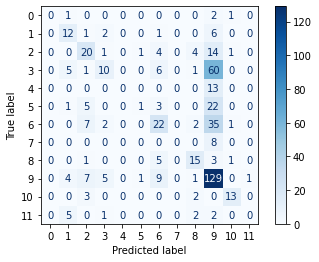


F1 scores: [0.         0.48       0.44444444 0.19230769 0.         0.05714286
 0.3697479  0.         0.57692308 0.57206208 0.74285714 0.        ]

Mean F1 : 0.286290433091007

Accuracy : 0.4567901234567901


In [ ]:
show_confusion(model, test_dataset)

In [ ]:
import matplotlib.pyplot as plt


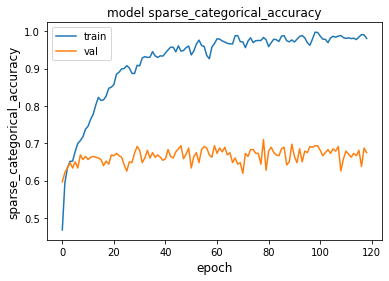

In [ ]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history[metric])
plt.plot(history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

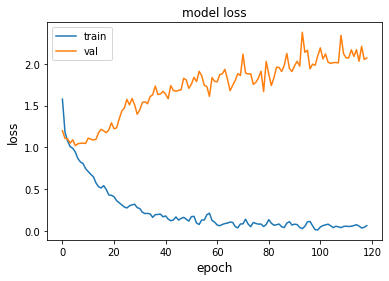

In [ ]:
metric = "loss"
plt.figure()
plt.plot(history[metric])
plt.plot(history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [ ]:
name = "./gdrive/MyDrive/ann_dataset/modelss/M0709"
model.save(name)

In [ ]:
"""with open("./scaler.p", "wb") as f:
  pickle.dump(scaler,f)
!zip -r ./gdrive/MyDrive/ann_dataset/HW2/scaler.zip ./scaler.p"""

  adding: scaler.p (deflated 23%)


# Adaboost trial
here we tried to use scikit learn ada boost implementation but the compatibility from version 2.5 of tensorflow is not guaranteed and we could not solve in reasonable time the compatibility issues

In [ ]:
def wrapper_boost(model):
  model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
  )
  return model


In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
class MyKerasClassifier(KerasClassifier):
    def fit(self, x, y, sample_weight=None, **kwargs):
      y = np.array(y)
      if len(y.shape) == 2 and y.shape[1] > 1:
          self.classes_ = np.arange(y.shape[1])
      elif (len(y.shape) == 2 and y.shape[1] == 1) or len(y.shape) == 1:
          self.classes_ = np.unique(y)
          y = np.searchsorted(self.classes_, y)
      else:
          raise ValueError('Invalid shape for y: ' + str(y.shape))
      self.n_classes_ = len(self.classes_)
      if sample_weight is not None:
          kwargs['sample_weight'] = sample_weight
          print(type(sample_weight))
      return super(MyKerasClassifier, self).fit(x, y, **kwargs)
    #return super(KerasClassifier, self).fit(x, y, sample_weight=sample_weight)
    def predict(self, x, **kwargs):
      kwargs = self.filter_sk_params(Sequential.predict_classes, kwargs)
      classes = self.model.predict_classes(x, **kwargs)
      return self.classes_[classes].flatten()
      #return super(KerasClassifier, self).fit(x, y, sample_weight=sample_weight)

In [ ]:
ann_estimator = KerasRegressor(build_fn= wrapper_boost(build_LSTM_classifier(input_shape=x_train.shape[1:])), epochs=100, batch_size=10, verbose=0)

<ipython-input-154-bdc2e53dcd43>:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ann_estimator = KerasRegressor(build_fn= wrapper_boost(build_LSTM_classifier(input_shape=x_train.shape[1:])), epochs=100, batch_size=10, verbose=0)


In [ ]:
boosted_ann = AdaBoostRegressor(base_estimator= ann_estimator)
boosted_ann.fit(x_train_norm, y_train_norm)# scale your training data 

ValueError: ignored

In [ ]:
boosted_ann.predict(test_dataset)

In [ ]:
!pip install tensorflow==2.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 454.4 MB 36 kB/s 
     |████████████████████████████████| 14.9 MB 59.4 MB/s 
     |████████████████████████████████| 132 kB 66.6 MB/s 
     |████████████████████████████████| 4.0 MB 48.9 MB/s 
     |████████████████████████████████| 462 kB 58.5 MB/s 
     |████████████████████████████████| 1.2 MB 51.9 MB/s 
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4849 sha256=d9af5510b93359ff64cbf41cfd5fba8da00158720522275e04c2876249410c9e
  Stored in directory: /root/.cache/pip/wheels/a0/16/9c/5473df82468f958445479c59e784896fa24f4a5fc024b0f501
  Created wheel for wrapt: filename=wrapt-1.12.1-cp38-cp38-linux_x86_64.whl size=72343 sha256=60c75a49b0efd67ed81997536e2761ddd5703c1469ae18b7bc77a43c70739ce3
  Stored in directory: /root/.cache/pip/wheels/5f/fd/9e/b6cf5890494cb8ef0b5eaff72e5d55a70fb56316007d6dfe73
Successfully built termc

In [ ]:
%tensorflow_version 2.5
boosted_classifier = AdaBoostClassifier(
    base_estimator=MyKerasClassifier(build_fn=build_LSTM_classifier, 
                                     epochs=5,
                                     batch_size=32, 
                                     verbose=0),
                                      n_estimators=2,
                                      random_state=0,
                                      algorithm="SAMME")

boosted_classifier.fit(x_train_norm,y_train_norm)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
<class 'numpy.ndarray'>


<ipython-input-179-40833adcfede>:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  base_estimator=MyKerasClassifier(build_fn=build_LSTM_classifier,


AttributeError: ignored